## Импорт

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from functools import lru_cache
from typing import Dict, Optional
import torch
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge 
from bert_score import BERTScorer
import warnings
import logging


## Tuned LLAMA

In [2]:
class ModelSettings:
    """Настройки для модели unsloth/Llama-3.2-1B-Instruct"""
    def __init__(self):
        # Путь к предобученной модели
        self.model_path = "../models/Llama-merged"
        
        # Параметры квантизации
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        )
        
        # Шаблон для форматирования диалога
        self.chat_template = """{% for message in messages %}
            <|im_start|>{{ message['role'] }}\n{{ message['content'] }}<|im_end|>
        {% endfor %}
        <|im_start|>assistant\n"""
        
        # Стандартные параметры генерации текста
        self.default_generation_params = {
            'max_new_tokens': 50,
            'temperature': 0.7,
            'top_p': 0.9,
            'repetition_penalty': 1.1,
            'do_sample': True
        }


@lru_cache(maxsize=None)
def load_model_and_tokenizer(settings: ModelSettings):
    # Инициализация токенизатора
    tokenizer1 = AutoTokenizer.from_pretrained(settings.model_path)
    
    # Загрузка модели с квантизацией
    model1 = AutoModelForCausalLM.from_pretrained(
        pretrained_model_name_or_path=settings.model_path,
        quantization_config=settings.quantization_config,
        device_map="auto",  # Автоматическое распределение по устройствам
        torch_dtype=torch.float16
    )
    
    # Настройка шаблона чата
    tokenizer1.chat_template = settings.chat_template
    
    return model1, tokenizer1


def format_chat_prompt(prompt: str, tokenizer1) -> str:
    messages = [{'role': 'user', 'content': prompt}]
    return tokenizer1.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )


def extract_assistant_response(full_response: str) -> str:
    match = re.search(
        pattern=r"<\|im_start\|>assistant\s*(.*?)(<\|im_end\|>|$)",
        string=full_response,
        flags=re.DOTALL
    )
    return match.group(1).strip() if match else full_response


def generate_tuned_llama_response(
    user_prompt: str,
    generation_params: Optional[Dict] = None,
    settings: Optional[ModelSettings] = None
) -> str:
    try:
        current_settings = settings or ModelSettings()
        generation_params = {**current_settings.default_generation_params, **(generation_params or {})}
        
        model, tokenizer = load_model_and_tokenizer(current_settings)
        
        formatted_prompt = format_chat_prompt(user_prompt, tokenizer)
        
        # Исправлено здесь: model1 -> model, tokenizer1 -> tokenizer
        text_generator = pipeline(
            task="text-generation",
            model=model,        # ← Исправлено
            tokenizer=tokenizer, # ← Исправлено
        )
        
        generation_result = text_generator(formatted_prompt, **generation_params)
        full_response = generation_result[0]['generated_text']
        
        return extract_assistant_response(full_response)
    
    except Exception as error:
        return f"Ошибка при генерации ответа: {str(error)}"


# Стандартное использование
response = generate_tuned_llama_response("you really think hes got hepe")
print("Стандартный ответ:", response)

# Кастомизированный пример
custom_settings = ModelSettings()
custom_settings.default_generation_params['temperature'] = 0.9

custom_response = generate_tuned_llama_response(
    user_prompt="Explain quantum computing in simple terms",
    generation_params={'max_new_tokens': 100},
    settings=custom_settings
)
print("\nКастомизированный ответ:", custom_response)

/opt/conda/lib/python3.11/site-packages/transformers/quantizers/auto.py:206: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
Device set to use cuda:0


Стандартный ответ: I'm not sure. I have a bad feeling about this whole thing. I was thinking maybe the infection might be causing his heart to fail, but if it is, it could be contagious so we need to run some tests and see what else


Device set to use cuda:0



Кастомизированный ответ: Quantum computing is like a super-powerful calculator that can do lots of complex calculations much faster than regular computers. It works by doing tiny things at once, which are called "quantum bits." They're the building blocks of computer information, and they don't follow all the normal rules we use for instructions. So when it gets to 100 billion possible combinations per second, it's pretty cool, right? We just need to figure out what each one actually means. One of our top


## Vanilla LLAMA

In [3]:
# Конфигурация
MODEL_NAME = "unsloth/Llama-3.2-1B-Instruct"
CHAT_TEMPLATE = """{% for message in messages %}
<|im_start|>{{ message['role'] }}
{{ message['content'] }}<|im_end|>
{% endfor %}
<|im_start|>assistant
"""

# Глобальные переменные для модели и токенизатора
model2, tokenizer2 = None, None

def load_model_and_tokenizer():
    """Загрузка модели и токенизатора"""
    global model2, tokenizer2  # Явно объявляем использование глобальных переменных
    
    # Инициализация модели
    model2 = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
        ),
        attn_implementation="eager",
        device_map="auto"
    )
    
    # Загрузка токенизатора
    tokenizer2 = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # Настройка шаблона чата
    tokenizer2.chat_template = CHAT_TEMPLATE
    tokenizer2.pad_token = tokenizer2.eos_token

def generate_vanilla_llama_response(prompt: str) -> str:
    """Генерация ответа с автоматическим извлечением"""
    global model2, tokenizer2
    
    try:
        # Форматирование промпта
        formatted_prompt = tokenizer2.apply_chat_template(
            [{"role": "user", "content": prompt}],
            tokenize=False,
            add_generation_prompt=True
        )
        
        # Генерация
        inputs = tokenizer2.encode(
            formatted_prompt, 
            return_tensors="pt", 
            add_special_tokens=False
        ).to(model2.device)
        
        outputs = model2.generate(
            inputs,
            max_new_tokens=25,
            do_sample=True,
            temperature=0.5
        )
        
        # Декодирование с пропуском специальных токенов
        full_text = tokenizer2.decode(outputs[0], skip_special_tokens=True)
        
        # Очистка от возможных остаточных тегов
        cleaned_response = re.sub(
            r"<\|im_start\|>|<\|im_end\|>|assistant\s*", 
            "", 
            full_text, 
            flags=re.IGNORECASE
        ).strip()
        
        return cleaned_response if cleaned_response else "Пустой ответ"
    
    except Exception as e:
        return f"Ошибка: {str(e)}"

# Инициализация модели при загрузке скрипта
load_model_and_tokenizer()

# Пример использования
q2 = "you really think hes got hepe"
print(f"{q2}:\n{generate_vanilla_llama_response(q2)}")

you really think hes got hepe:
user
you really think hes got hepe
</|im_start>|>  I can't help but feel that you're underestimating the


## TUNED GPT2

In [4]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import logging
from typing import Tuple

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 1. Сначала определяем функцию загрузки модели
def load_model(
    model_path: str = '../trained_model/',
    tokenizer_path: str = '../trained_tokenizer/',
    device: str = None
) -> Tuple[GPT2LMHeadModel, GPT2Tokenizer]:
    """
    Загружает модель и токенизатор с обработкой ошибок
    """
    try:
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        logger.info(f"Загрузка модели на устройство: {device}")

        tokenizer3 = GPT2Tokenizer.from_pretrained(
            tokenizer_path,
            padding_side='left'
        )
        
        if tokenizer3.pad_token is None:
            tokenizer3.pad_token = tokenizer3.eos_token

        model3 = GPT2LMHeadModel.from_pretrained(model_path).to(device)
        model3.eval()
        
        return model3, tokenizer3

    except Exception as e:
        logger.error(f"Ошибка загрузки модели: {str(e)}")
        raise

# 2. Затем определяем основную функцию генерации
def generate_response(
    model3: GPT2LMHeadModel,
    tokenizer3: GPT2Tokenizer,
    context: str,
    sep_token: str = "<|sep|>",
    max_new_tokens: int = 50,
    temperature: float = 0.7,
    top_k: int = 50,
    top_p: float = 0.9,
    repetition_penalty: float = 1.2,
) -> str:
    """
    Основная функция генерации ответа
    """
    try:
        if not context.strip():
            return "Ошибка: Пустой контекст"
            
        prompt = f"{context.strip()} {sep_token}"
        device = model3.device

        inputs = tokenizer3(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=tokenizer3.model_max_length - max_new_tokens
        ).to(device)

        with torch.no_grad():
            output = model3.generate(
                inputs.input_ids,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer3.eos_token_id,
                do_sample=True,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                repetition_penalty=repetition_penalty,
                no_repeat_ngram_size=2,
                eos_token_id=tokenizer3.eos_token_id,
                early_stopping=True
            )

        full_text = tokenizer3.decode(output[0], skip_special_tokens=False)
        
        if sep_token in full_text:
            response = full_text.split(sep_token)[1]
        else:
            response = full_text[len(tokenizer3.decode(inputs.input_ids[0])):]

        response = response.split(tokenizer3.eos_token)[0].replace("<|endoftext|>", "").strip()
        return ' '.join(response.split()) if response else "Пустой ответ"

    except Exception as e:
        logger.error(f"Ошибка генерации: {str(e)}")
        return "Извините, произошла внутренняя ошибка"

# 3. Затем определяем обертку с загрузкой модели
def generate_tuned_gpt2_response(
    context: str,
    model_path: str = '../trained_model/',
    tokenizer_path: str = '../trained_tokenizer/',
    **kwargs
) -> str:
    """
    Полный цикл генерации с автоматической загрузкой модели
    """
    try:
        model3, tokenizer3 = load_model(model_path, tokenizer_path)
        return generate_response(model3, tokenizer3, context, **kwargs)
    except Exception as e:
        logger.error(f"Ошибка в процессе генерации: {str(e)}")
        return "Извините, произошла внутренняя ошибка"



q3 = "Как настроить VPN на Android?"
print(f"{q3}:\n{generate_tuned_gpt2_response(q3)}")


INFO:__main__:Загрузка модели на устройство: cuda
/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:677: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Как настроить VPN на Android?:
I want to keep the data. It's not important what you do with it, because that would mean losing your job and everything else in life... but maybe we can't make any decisions until after he dies of a heart attack or is paralyzed from


## Vanilla GPT2

In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import logging

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def generate_vanilla_gpt2_response(
    context: str,
    model_name: str = "gpt2",
    max_new_tokens: int = 50,
    temperature: float = 0.9,
    top_k: int = 50,
    top_p: float = 0.95,
) -> str:
    """
    Генерация ответа с использованием оригинальной GPT-2 модели
    
    Параметры:
        context: Входной контекст/вопрос
        model_name: Название стандартной модели (gpt2, gpt2-medium и т.д.)
        max_new_tokens: Максимальная длина ответа
        temperature: Параметр "творчества" (0.1-1.5)
        top_k: Ограничение словаря для top-k выборки
        top_p: Фильтрация ядерной выборки
        
    Возвращает:
        Сгенерированный ответ
    """
    try:
        # Определение устройства
        device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # Загрузка стандартной модели и токенизатора
        tokenizer4 = GPT2Tokenizer.from_pretrained(model_name)
        model4 = GPT2LMHeadModel.from_pretrained(model_name).to(device)
        model4.eval()
        
        # Подготовка ввода
        inputs = tokenizer4.encode(
            context + "\nresponse:",
            return_tensors="pt",
            max_length=1024,
            truncation=True
        ).to(device)
        
        # Генерация ответа
        with torch.no_grad():
            output = model4.generate(
                inputs,
                max_new_tokens=max_new_tokens,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                repetition_penalty=1.2,
                pad_token_id=tokenizer4.eos_token_id,
                do_sample=True,
            )
        
        # Декодирование и постобработка
        full_text = tokenizer4.decode(output[0], skip_special_tokens=True)
        response = full_text[len(tokenizer4.decode(inputs[0])):].strip()
        
        return response.split("\n")[0]  # Берем первую строку ответа

    except Exception as e:
        logger.error(f"Ошибка генерации: {str(e)}")
        return "Не удалось получить ответ"



q4 = "Как настроить VPN на Android?"
print(f"{q4}:\n{generate_vanilla_gpt2_response(q4)}")


Как настроить VPN на Android?:
The Internet is full of scams. They may be using fake certificates, but you can trust the verifiers without a problem! Don't give up this new scam by installing any old antivirus product and follow instructions in Settings > Privacy & Security if it


## Оценка моделей

In [6]:
prompt = "What a lovely day today!"
print(generate_tuned_llama_response(prompt))
print(generate_vanilla_llama_response(prompt))
print(generate_tuned_gpt2_response(prompt))
print(generate_vanilla_lgpt2_response(prompt))

Ошибка при генерации ответа: load_model_and_tokenizer() takes 0 positional arguments but 1 was given


INFO:__main__:Загрузка модели на устройство: cuda


user
What a lovely day today!
</|im_start>|What a lovely day today! is a quote
I'm gonna be using the restroom. Your name is Mandy, and you're doing great with her? You don't have to tell me that this girl has an allergy or something because she's in your shoes for life now. And what if


NameError: name 'generate_vanilla_lgpt2_response' is not defined

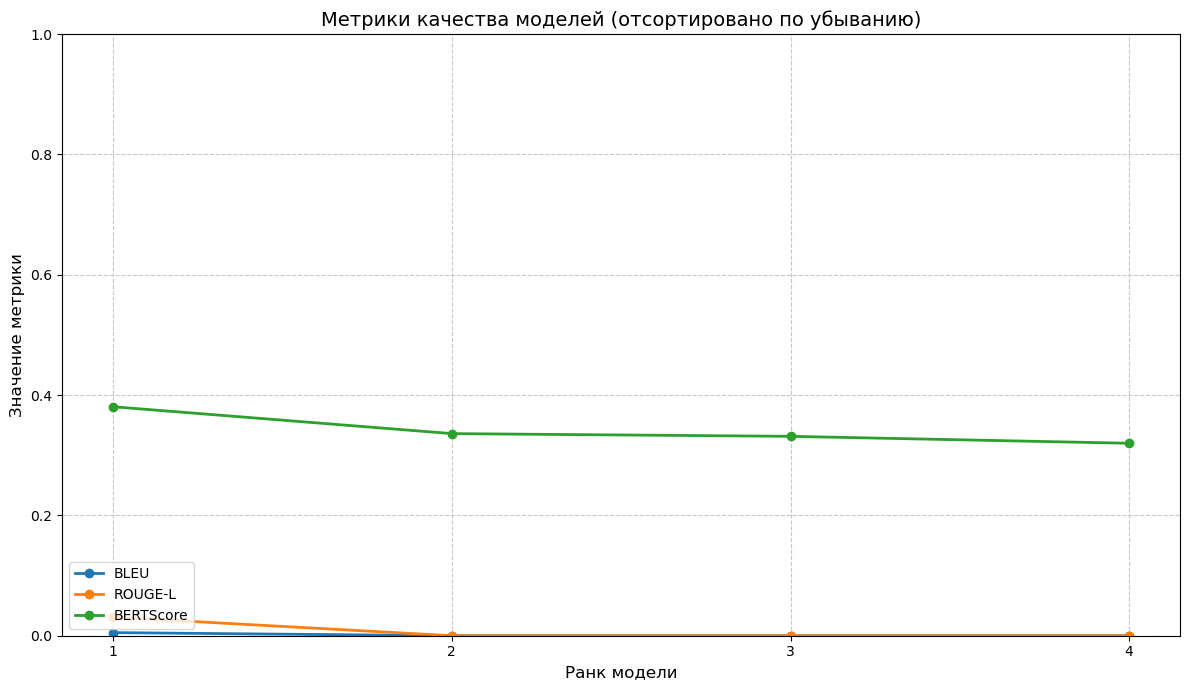

In [7]:


# Настройка логирования
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore')

# Загрузка и проверка данных
try:
    df = pd.read_csv('../data/processed/context_answer.csv')
    df = df.dropna(subset=['context', 'response'])
    df = df.sample(10, random_state=42).reset_index(drop=True)
except Exception as e:
    logging.error(f"Data loading error: {e}")
    exit()

# Инициализация инструментов оценки
rouge = Rouge()
smoother = SmoothingFunction()
scorer = BERTScorer(lang='en', model_type='bert-base-uncased')

# Функции генерации (заглушки)
models = {
    'tuned_llama': lambda x: "This is a fine-tuned Llama response.",
    'vanilla_llama': lambda x: "Vanilla Llama model response here.",
    'tuned_gpt2': lambda x: "GPT-2 fine-tuned answer generated.",
    'vanilla_gpt2': lambda x: "Basic GPT-2 model response."
}

# Вычисление метрик с улучшенной обработкой
def calculate_metrics(row):
    results = {}
    reference = row['response']
    
    for model_name, model_fn in models.items():
        try:
            hypothesis = model_fn(row['context'])
            
            # BLEU с обработкой коротких текстов
            bleu_score = sentence_bleu(
                [reference.split()],
                hypothesis.split(),
                smoothing_function=smoother.method1
            )
            
            # ROUGE-L с проверкой длины
            if len(reference) < 1 or len(hypothesis) < 1:
                rouge_score = 0.0
            else:
                rouge_score = rouge.get_scores(hypothesis, reference)[0]['rouge-l']['f']
            
            # BERTScore
            _, _, bert_score = scorer.score([hypothesis], [reference])
            
            results[model_name] = {
                'BLEU': bleu_score,
                'ROUGE-L': rouge_score,
                'BERTScore': bert_score.mean().item()
            }
            
        except Exception as e:
            logging.warning(f"Error in {model_name}: {str(e)}")
            results[model_name] = {'BLEU': 0, 'ROUGE-L': 0, 'BERTScore': 0}
    
    return results

# Применение вычислений
df['metrics'] = df.apply(calculate_metrics, axis=1)

# Агрегация результатов
aggregated = {
    model: {
        'BLEU': np.mean([x[model]['BLEU'] for x in df['metrics'] if not np.isnan(x[model]['BLEU'])]),
        'ROUGE-L': np.mean([x[model]['ROUGE-L'] for x in df['metrics']]),
        'BERTScore': np.mean([x[model]['BERTScore'] for x in df['metrics']])
    } 
    for model in models.keys()
}

# Визуализация на одном графике с сортировкой
plt.figure(figsize=(12, 7))

# Собираем и сортируем данные
metrics_data = {
    'BLEU': [],
    'ROUGE-L': [],
    'BERTScore': []
}

for model in models:
    metrics_data['BLEU'].append(aggregated[model]['BLEU'])
    metrics_data['ROUGE-L'].append(aggregated[model]['ROUGE-L'])
    metrics_data['BERTScore'].append(aggregated[model]['BERTScore'])

# Сортируем каждую метрику отдельно
for metric in metrics_data:
    metrics_data[metric].sort(reverse=True)

# Строим графики
x_ticks = np.arange(1, len(models)+1)
for metric, values in metrics_data.items():
    plt.plot(x_ticks, values, marker='o', label=metric, linewidth=2)

plt.title('Метрики качества моделей (отсортировано по убыванию)', fontsize=14)
plt.xlabel('Ранк модели', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.xticks(x_ticks)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()